In [26]:
# GT Project
# For xgboost modeling
# Claire Hu
#
#Version 3.0
#

import xgboost as xgb
import numpy as np
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import datetime, time
import os
import random
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

random.seed(888)

In [27]:
verbose = 1000

random_state = 888

DT_format = "%Y%m%d%H%M%S"

work_dir = ''

currentDT = datetime.datetime.now()
model_version = currentDT.strftime(DT_format)

data_file = work_dir + 'RawData_ZERO.csv'
print('Is loading the training file from:', data_file)
    
feature_importance_file = work_dir + 'feature_importance.txt'

text_model_store_location = work_dir + 'models/'
if not os.path.exists(text_model_store_location):
    os.makedirs(text_model_store_location)
print('Xgboost model will store at:', text_model_store_location)
model_file = text_model_store_location + 'creditcard_xgboost_model_' + model_version + '.md'
    
AUC_ROC_CURVE_SAVING_PATH = work_dir + 'PERFORMANCE_CHARTS/'
    
if not os.path.exists(AUC_ROC_CURVE_SAVING_PATH):
    os.makedirs(AUC_ROC_CURVE_SAVING_PATH)

CUT_RATIO = 0.7



param = {
    'max_depth': 5,  # the maximum depth of each tree
    'eta': 0.1,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'binary:logistic',  # error evaluation for multiclass training # binary:logistic #multi:softprob
    'scale_pos_weight': 1.0,
    'feature_selector': 'greedy',
    #'tree_method': 'hist',
    #'grow_policy': 'lossguide', # depthwise #Controls a way new nodes are added to the tree.
}  # the number of classes that exist in this datset #'num_class': 2

num_round = 200  # the number of training iterations

feature_name_str = "Restatement_Classifier,CIK,CFOChange,PriorRestatements,PriorRevisions,PYEffectiveControls,ticker,Periodend,Auditor_Key,AuditorBigFour,AuditorNextFour,AuditorSmall,AuditFeeTotal,tag_count,XBRLExtendedPct,Market_Cap,Cash,AccountsReceivable,AllowanceForDoubtfulAccountsReceivable,Inventory,ShortTermInvestments,CurrentAssets,PPE,Assets,AccountsPayable,ShortTermDebt,CurrentTaxliability,NoncurrentTaxLiability,CurrentLiabilities,LongTermDebt,Liabilities,StockholdersEquity,PreferredStockValue,CommonStockValue,RetainedEarnings,RevenueAdjusted,CostOfRevenue,DepreciationAmortization,DepreciationAndAmortizationExpense,SGAExpense,InterestExpense,NetInterestIncome,IncomeTaxes,NetIncomeContinuingOperations,NetIncome,FinancingCashFlow,Revenue,ExciseAndSalesTaxes,NonInterestIncome,ProvisionForLoanLoss,GrossProfit,ResearchAndDevelopment,OperatingExpenses,OperatingExpenseExItems,OperatingIncome,EBIT,InterestIncome,EBITDA,EarningsBeforeTaxes,NoncontrollingInterestNetIncome,NetIncomeDiscontinuedOperations,NetIncomeCommonStockholders,EPSBasic,EPSDiluted,AvgSharesOutstandingBasic,AvgDilutedSharesOutstanding,CommonStockDividendsPerShare,RestrictedCashAndInvestmentsCurrent,LongTermInvestments,LIFOInventoryReserve,LoansHeldForSale,CurrentTaxAsset,AccumulatedDepreciation,AccruedIncomeTaxes,LoansReceivable,LoansReceivableCommercial,LoansReceivableConsumer,LoansAllowance,Goodwill,IntangibleAssetsExcludingGoodwill,NoncurrentTaxAsset,Deposits,InterestExpense_footnote,CurrentLongTermDebt,TotalDebt,DeferredRevenue,DeferredRevenueCurrent,DeferredRevenueNoncurrent,AdditionalPaidInCapital,TreasuryStockValue,StockholdersEquityBeforeNCI,NoncontrollingInterest,MezzanineValues,SharesAuthorized,SharesIssued,InventoryIncreaseDecrease,ReceivablesIncreaseDecrease,PayablesIncreaseDecrease,AccruedLiabilitiesIncreaseDecrease,ShareBasedCompensation,OperatingCashFlow,CAPEXgross,CapitalAssetSales,CAPEX,AcquisitionDivestitures,InvestingCashFlow,PaymentsOfDividends,PaymentsOfDividendsCommonStock,PaymentsOfDividendsPreferredStock,PaymentsOfDividendsNoncontrollingInterest,EffectOfExchangeRateOnCash,CashIncrease,AccruedLiabilities,BilledContractReceivables,UnbilledReceivablesNotBillableAtBalanceSheetDateAmountExpectedToBeCollectedAfterOneYear,AllowanceForDoubtfulAccountsReceivableWriteOffs,AllowanceForDoubtfulAccountsReceivableRecoveries,CostsInExcessOfBillings,TierOneRiskBasedCapital,ExcessTierOneRiskBasedCapital,TierOneLeverageCapital,ExcessTierOneLeverageCapital,TierTwoRiskBasedCapital,RegulatoryCapital,ExcessCapital,TierOneRiskBasedCapitalToRiskWeightedAssets,ExcessTierOneRiskBasedCapitalToRiskWeightedAssets,CapitalToRiskWeightedAssets,CommercialLoansReceivable,AutoLoanReceivable,TotalConsumerLoansReceivable,FinancingReceivableAllowanceForCreditLosses,ProvisionForLoanLeaseAndOtherLosses,FinancingReceivableAllowanceForCreditLossesWriteOffs,FinancingReceivableAllowanceForCreditLossesRecovery,ServicingFeesNet,RealEstateAcquiredThroughForeclosure,RealEstateOwnedValuationAllowance,NonPerformingLoans,FinancingReceivableRecordedInvestmentPastDue,AllowanceForLoanAndLeaseLossesWriteoffsNet,AllowanceForLoanAndLeaseLossesWriteOffs,ValuationAllowancesAndReservesRecoveries,PaymentsToAcquireBusinessesGross,BusinessCombinationConsiderationTransferredIncludingEquityInterestInAcquireeHeldPriorToCombination1,FinitelivedIntangibleAssetsAcquired,BusinessCombinationRecognizedIdentifiableAssetsAcquiredAndLiabilitiesAssumedAssets,BusinessAcquisitionCostOfAcquiredEntityTransactionCosts,CapitalLeaseObligations,CapitalLeasesFutureMinimumPaymentsDue,EffectOfExchangeRateOnCashAndCashEquivalents,LossContingencyRangeOfPossibleLossMaximum,LossContingencyRangeOfPossibleLossMinimum,AssetRetirementObligation,ContractualObligation,OtherCommitment,LegalFees,PaymentsForLegalSettlements,LitigationReserve,AccumulatedOtherComprehensiveIncomeLossNetOfTax,SoftAssets,DSO,AuditFeeTotal_CS,LoansAllowance_CS,Goodwill_CS,IntangibleAssetsExcludingGoodwill_CS,LegalFees_CS,PaymentsForLegalSettlements_CS,LitigationReserve_CS,SoftAssets_CS,PaymentsToAcquireBusinessesGross_CS,XBRLExtendedPct_YOY,tag_count_YOY,Cash_YOY,AccountsReceivable_YOY,AllowanceForDoubtfulAccountsReceivable_YOY,Inventory_YOY,PPE_YOY,Assets_YOY,ShortTermDebt_YOY,LongTermDebt_YOY,StockholdersEquity_YOY,RevenueAdjusted_YOY,DepreciationAmortization_YOY,InterestExpense_YOY,NetIncome_YOY,ResearchAndDevelopment_YOY,LongTermInvestments_YOY,Goodwill_YOY,IntangibleAssetsExcludingGoodwill_YOY,InterestExpense_footnote_YOY,TotalDebt_YOY,DeferredRevenue_YOY,ShareBasedCompensation_YOY,AcquisitionDivestitures_YOY,InvestingCashFlow_YOY,LegalFees_YOY,PaymentsForLegalSettlements_YOY,LitigationReserve_YOY,SoftAssets_YOY,DSO_YOY,Market_Cap_YOY,RevenueToPrefStock,SGAExpense_to_LTInvest,Assets_to_LTInvest,Revenue_to_LTInvest,Assets_to_STInvest,FirstTenK,WCAccruals"

feature_name_list = feature_name_str.split(',')

Is loading the training file from: RawData_NEGONE.csv
Xgboost model will store at: models/


In [28]:
def gen_generator(layout_list):
    layout_dict = {}
    for index in range(len(layout_list)):
        feature_name = layout_list[index]
        layout_dict[feature_name] = index
    return layout_dict

layout = gen_generator(feature_name_list)

In [29]:
def feature_selection():

    training_set = set()
    training_list = []
    with open(feature_importance_file, 'r') as f:
        for line in f:

            line_list = line.strip('\n').split(':')
            feature_name = line_list[1].split('\t')[0].strip()
            importance = float(line_list[-1].strip(''))
            print(feature_name, importance)

            if importance >= 1:
                training_list.append(feature_name)
                training_set.add(feature_name)

    return training_list, training_set
training_list, training_set = feature_selection()

UnbilledReceivablesNotBillableAtBalanceSheetDateAmountExpectedToBeCollectedAfterOneYear 408.999512
PaymentsOfDividendsCommonStock 269.5611121474083
PaymentsOfDividendsNoncontrollingInterest 207.688721
ServicingFeesNet 197.054901
NonInterestIncome 190.13126375000002
NetIncome_YOY 123.24438649140583
PYEffectiveControls 112.528497297725
MezzanineValues 90.5804725392857
PaymentsToAcquireBusinessesGross_CS 85.23365789828574
RegulatoryCapital 82.0415421
LoansAllowance 76.5518188
Periodend 71.93133300548843
LegalFees 71.2603917354
LongTermInvestments_YOY 70.60425001099999
AllowanceForDoubtfulAccountsReceivableRecoveries 66.11177282550001
AssetRetirementObligation 63.26329193725001
PaymentsForLegalSettlements_CS 62.8392906
Market_Cap 61.57937859687371
LongTermInvestments 59.515723007500014
FinancingReceivableAllowanceForCreditLosses 56.205821075
DeferredRevenueCurrent 49.42015165822307
IntangibleAssetsExcludingGoodwill 46.52594262158751
NoncontrollingInterestNetIncome 46.32764043714286
LoansRe

In [30]:
def record_counter():
    counter = 0
    with open(data_file, 'r') as f:
        for line in f:
            if "Restatement_Classifier" not in line:
                counter += 1

    return counter
num_records = record_counter()

In [31]:
def gen_whole_data_time_series():
    feature_train = []
    target_train = [] 

    feature_test = []
    target_test = []

    start = time.time()

    index = 0
    with open(data_file, 'r') as f:
        for line in f:
            line_list = line.strip('\n').split(',')

            if "Restatement_Classifier" not in line:
                target = int(line_list[layout['Restatement_Classifier']].strip(''))
                feature_list_str = line_list[1:]

                if index % verbose == 0:
                    print('Have processed number of transactions:', index, 'time cost:', time.time() - start)
                    start = time.time()

                feature_list_float = []

                for feature_name in training_list:

                    selected_index = layout[feature_name]
                    feature_val = line_list[selected_index]
                    feature_list_float.append(float(feature_val))


                if index <= int(float(num_records) * float(CUT_RATIO)):

                    feature_train.append(feature_list_float)
                    target_train.append(target)

                else:

                    feature_test.append(feature_list_float)
                    target_test.append(target)

                index += 1

    return feature_train, target_train, feature_test, target_test

In [32]:
def over_sample_generator_time_series():
    ros = RandomOverSampler(random_state = random_state)
    feature_train, target_train, feature_test, target_test = gen_whole_data_time_series()
    feature_train_resampled, target_train_resampled = ros.fit_resample(feature_train, target_train)
    return feature_train_resampled, target_train_resampled, feature_test, target_test


def under_sample_generator_time_series():
    rus = RandomUnderSampler(random_state = random_state)
    feature_train, target_train, feature_test, target_test = gen_whole_data_time_series()
    feature_train_resampled, target_train_resampled = rus.fit_resample(feature_train, target_train)
    return feature_train_resampled, target_train_resampled, feature_test, target_test


def SMOTE_sample_generator_time_series():
    sm = SMOTE(random_state=42)
    feature_train, target_train, feature_test, target_test = gen_whole_data_time_series()
    feature_train_resampled, target_train_resampled = sm.fit_resample(feature_train, target_train)
    return feature_train_resampled, target_train_resampled, feature_test, target_test

In [33]:
sample_selection_mode = 'time_series_under'

data_processing_start = time.time()
if sample_selection_mode == 'time_series':
    print('Is using time_series sampling mode...')
    feature_train, target_train, feature_test, target_test = gen_whole_data_time_series()

elif sample_selection_mode == 'time_series_over':
    print('Is using time_series_over mode...')
    feature_train, target_train, feature_test, target_test = over_sample_generator_time_series()

elif sample_selection_mode == 'time_series_under':
    print('Is using time_series_under mode...')
    feature_train, target_train, feature_test, target_test = under_sample_generator_time_series()

else:
    print('Is using time_series_smote mode...')
    feature_train, target_train, feature_test, target_test = SMOTE_sample_generator_time_series()


print('Total time to process all data is:', time.time() - data_processing_start)

Is using time_series_under mode...
Have processed number of transactions: 0 time cost: 0.00034999847412109375
Have processed number of transactions: 1000 time cost: 0.06661415100097656
Have processed number of transactions: 2000 time cost: 0.05614805221557617
Have processed number of transactions: 3000 time cost: 0.055235862731933594
Have processed number of transactions: 4000 time cost: 0.05640816688537598
Have processed number of transactions: 5000 time cost: 0.05183911323547363
Have processed number of transactions: 6000 time cost: 0.05989503860473633
Have processed number of transactions: 7000 time cost: 0.05681777000427246
Have processed number of transactions: 8000 time cost: 0.055253028869628906
Have processed number of transactions: 9000 time cost: 0.05275607109069824
Have processed number of transactions: 10000 time cost: 0.058943986892700195
Have processed number of transactions: 11000 time cost: 0.05863070487976074
Have processed number of transactions: 12000 time cost: 0.07

In [34]:
print('Length of training dataset:', len(feature_train), len(target_train))
print('Length of validation dataset:', len(feature_test), len(target_test))

Length of training dataset: 1394 1394
Length of validation dataset: 10362 10362


In [38]:
###############    RANDOM FOREST #############################

from sklearn.ensemble import RandomForestClassifier

model_randomforest_v01 = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
model_randomforest_v01.fit(feature_train, target_train)

y_pred_random_forest_v01 = model_randomforest_v01.predict(feature_test)
y_true = target_test

AUC_ROC_SCORE_random_forest_v01 = roc_auc_score(y_true, y_pred_random_forest_v01)
print('AUC for random forest is:', AUC_ROC_SCORE_random_forest_v01)

#######################################################################################

AUC for random forest is: 0.623467161646583


In [39]:
def gen_ratio(target_train):
    gd_trxn_counter = 0
    fd_trxn_counter = 0

    for item in target_train:
        if item == 1.0:
            fd_trxn_counter += 1
        else:
            gd_trxn_counter += 1

    ratio = float(gd_trxn_counter) / float(fd_trxn_counter)
    print('Number of good transactions in training dataset:', gd_trxn_counter)
    print('Number of fraud transactions in training dataset::', fd_trxn_counter)
    print('GOOD/FRAUD Ratio:', ratio, '\n')
    return ratio
ratio = gen_ratio(target_train)

Number of good transactions in training dataset: 697
Number of fraud transactions in training dataset:: 697
GOOD/FRAUD Ratio: 1.0 



In [40]:
param['scale_pos_weight'] = ratio

print('Using following parameters:')
for key in param:
    print(key, param[key])
print('\n')




Using following parameters:
max_depth 5
eta 0.1
silent 1
objective binary:logistic
scale_pos_weight 1.0
feature_selector greedy




In [42]:
def train_model_xgboost(feature_train, target_train):

    dtrain = xgb.DMatrix(feature_train, label=target_train, feature_names=training_list)
    bst = xgb.train(param, dtrain, num_round)
    bst.dump_model(model_file)
    return bst
    
print("Is training the xgboost model...")
start = time.time()
model_bst = train_model_xgboost(feature_train, target_train)
print("Training process finished! Time cost:", time.time() - start)

Is training the xgboost model...
Training process finished! Time cost: 0.5540437698364258


In [44]:

def inference_xgboost(bst, feature_test, target_test):
    dtest = xgb.DMatrix(feature_test, label=target_test, feature_names=training_list)
    preds = bst.predict(dtest)
    return preds

print('Is inference the predicted results by using the validation data...')
prediction_result = inference_xgboost(model_bst, feature_test, target_test)
print('Inference finished!')

Is inference the predicted results by using the validation data...
Inference finished!


In [45]:
def print_feature_importance(importance_dict):
    sorted_importance_dict = sorted(importance_dict.items(), key=lambda kv: kv[1], reverse=True)
    print('Credit Card Fraud Detection Feature Importance List:')
    for item in sorted_importance_dict:
        print('Feature Name:', item[0], '\t\t', 'Feature Abs_importance:', item[1])
            
print("Generating the feature importance list...")
importance_dict = model_bst.get_score(importance_type='gain')
print_feature_importance(importance_dict)

Generating the feature importance list...
Credit Card Fraud Detection Feature Importance List:
Feature Name: NetIncomeContinuingOperations 		 Feature Abs_importance: 8.153451882633332
Feature Name: PaymentsOfDividendsCommonStock 		 Feature Abs_importance: 7.11447237128
Feature Name: PYEffectiveControls 		 Feature Abs_importance: 6.162814567473686
Feature Name: Periodend 		 Feature Abs_importance: 5.761760067450981
Feature Name: Goodwill_YOY 		 Feature Abs_importance: 5.478892923157893
Feature Name: MezzanineValues 		 Feature Abs_importance: 4.650285064999999
Feature Name: CommonStockDividendsPerShare 		 Feature Abs_importance: 4.6295495
Feature Name: TierOneRiskBasedCapital 		 Feature Abs_importance: 4.50586128
Feature Name: IntangibleAssetsExcludingGoodwill 		 Feature Abs_importance: 4.391516066222222
Feature Name: NetIncome_YOY 		 Feature Abs_importance: 4.328170148394318
Feature Name: LongTermDebt 		 Feature Abs_importance: 4.325437632160001
Feature Name: ValuationAllowancesAndReser

In [47]:
fpr, tpr, threshold = metrics.roc_curve(np.array(target_test), np.array(prediction_result))
roc_auc = metrics.auc(fpr, tpr)
print('The xgboost model performance of AUC-ROC value:', roc_auc)

The xgboost model performance of AUC-ROC value: 0.6833640758806867


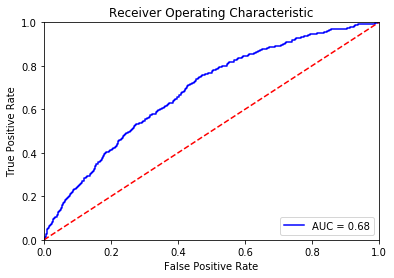

The AUC curve chart been saved at location: PERFORMANCE_CHARTS/xgboost_AUC_ROC_20200124040945.jpg


<Figure size 432x288 with 0 Axes>

In [49]:
def gen_AUC_CURVE(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    plt.savefig(AUC_ROC_CURVE_SAVING_PATH + 'xgboost_AUC_ROC_' + model_version + '.jpg')
    
gen_AUC_CURVE(fpr, tpr, roc_auc)

print('The AUC curve chart been saved at location:', AUC_ROC_CURVE_SAVING_PATH + 'xgboost_AUC_ROC_' + model_version + '.jpg')
